In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e5/sample_submission.csv
/kaggle/input/playground-series-s4e5/train.csv
/kaggle/input/playground-series-s4e5/test.csv


In [2]:
import matplotlib.pyplot as plt

# 1. Load the dataset

In [3]:
data= pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv')
data.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,...,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,...,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,...,7,3,7,5,6,8,2,3,3,0.530
3,3,3,4,6,5,4,8,4,7,6,...,2,4,7,4,4,6,5,7,5,0.535
4,4,5,3,2,6,4,4,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


# 2. Exploratory Data Analysis

/tmp/ipykernel_17/1442563091.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.hist(bins=20, ax=ax1)


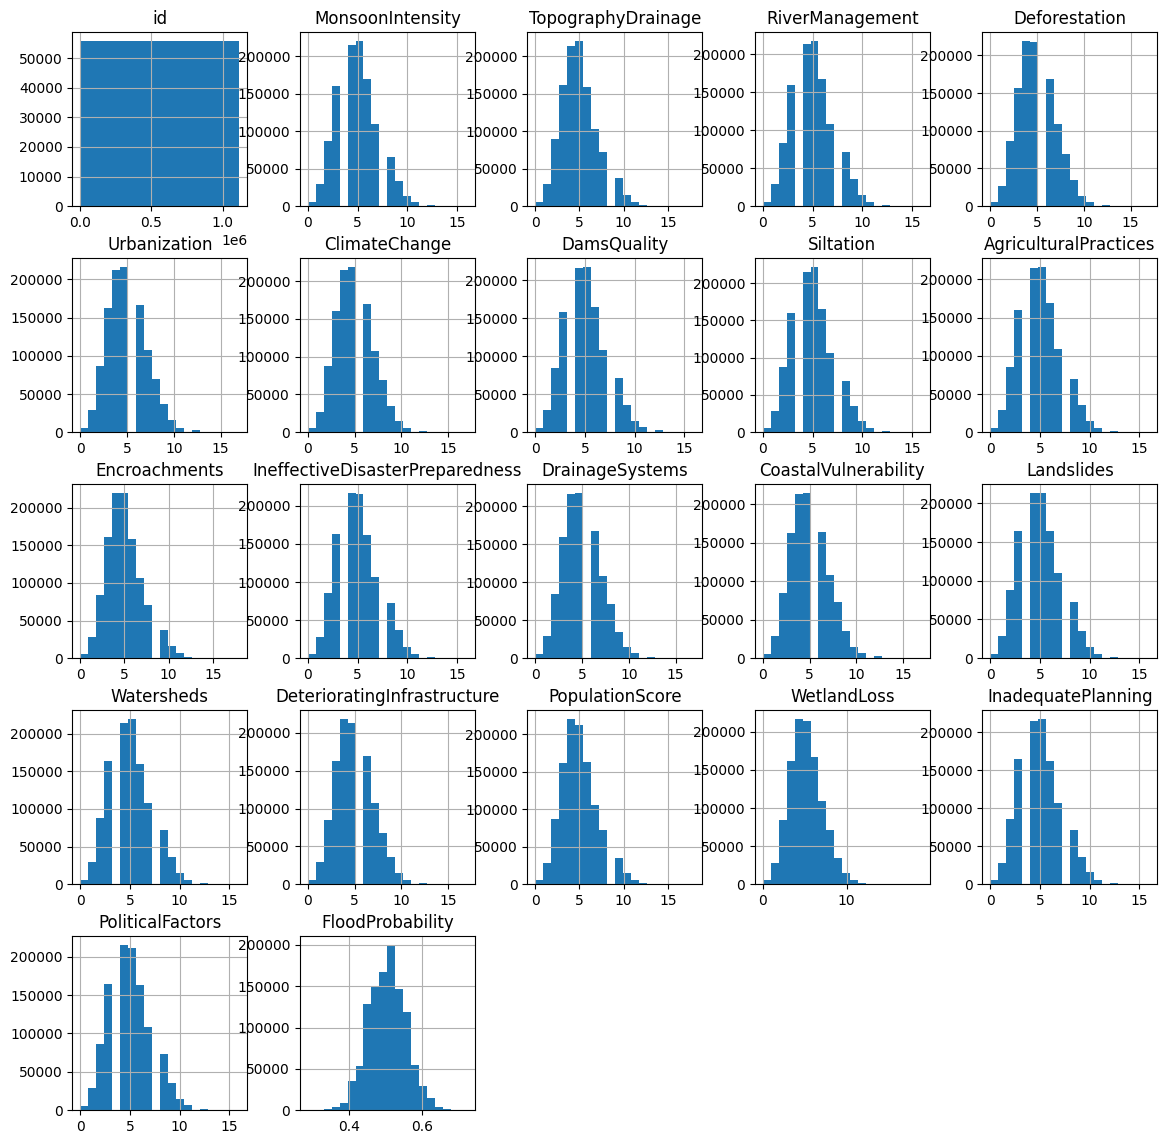

In [4]:
plt.close()
fig = plt.figure(figsize=(14, 14), dpi=100)
ax1 = fig.add_subplot(111)
data.hist(bins=20, ax=ax1)
plt.show()

## 2. Split the data to Training and Validation Sets

In [5]:
from sklearn.model_selection import train_test_split

X = data.drop(['id', 'FloodProbability'], axis=1)
y = data['FloodProbability']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Standardize the Features¶

We will standardize the features using the z-score $$z=\frac{(x-\mu)}{\sigma}$$,
where μ is the mean of the feature, σ is the standard deviation of this feature. We will incorporate that using `sklearn.preprocessing.StandardScaler`

In [6]:
from sklearn.preprocessing import StandardScaler
# Initialize the StandardScaler()
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation data
X_valid_scaled = scaler.fit_transform(X_valid)

# 3. Model 
We will use XGBoost to perform linear regression


## a. Convert data to DMatrix

In [7]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid)

## b. Set the parameters for linear regression

In [8]:
params = {
    'booster': 'gblinear', 
    'objective': 'reg:squarederror', 
    'alpha': 0.001, # L1 regularization term on weights
    'lambda': 1.0,  # L2 regularization term on weights
    'learning_rate': 0.01, 
    'num_boost_round': 100
}

## c. Train the model

In [9]:
model = xgb.train(params, dtrain, num_boost_round=params['num_boost_round'])

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [03:10:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)


# 4. Make predictions on the validation test

In [10]:
y_pred_valid = model.predict(dvalid)

# 5. Evaluate the model

In [11]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_valid, y_pred_valid)
r2 = r2_score(y_valid, y_pred_valid)

print(f"Mean Squared Error: {mse} ")
print(f"R-squared: {r2}")

Mean Squared Error: 0.0016822977699807488 
R-squared: 0.352782123114883


# 5. Checking Assumptions

## a. Linearity:

   * Check that the relationship between the dependent and independent variables is linear.

## b. Independence:

   * Ensure observations are independent.

## c. Homoscedasticity:

   * Residuals (errors) should have constant variance.

## d. Normality of Residuals:

   * Residuals should be approximately normally distribute

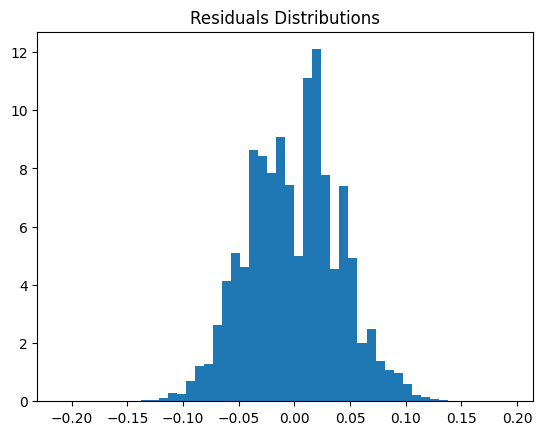

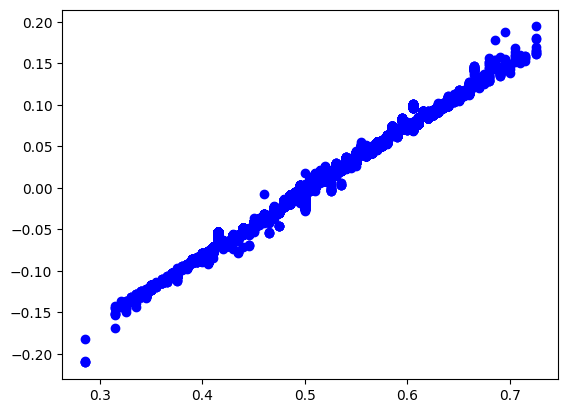

In [12]:


y_diff = y_valid - y_pred_valid
plt.close()
plt.hist(y_diff, bins=50, density=True)
plt.title("Residuals Distributions")
plt.show()

plt.close()
plt.plot(y_valid, y_diff, 'bo')
plt.show()



# 6. Perform the prediction on the Testing Set

In [13]:
test = pd.read_csv('/kaggle/input/playground-series-s4e5/test.csv')
test.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
0,1117957,4,6,3,5,6,7,8,7,8,...,8,5,7,5,6,3,6,4,4,5
1,1117958,4,4,2,9,5,5,4,7,5,...,2,4,7,4,5,1,7,4,4,3
2,1117959,1,3,6,5,7,2,4,6,4,...,7,9,2,5,5,2,3,6,8,3
3,1117960,2,4,4,6,4,5,4,3,4,...,7,8,4,6,7,6,4,2,4,4
4,1117961,6,3,2,4,6,4,5,5,3,...,4,3,2,6,4,6,8,4,5,5


In [14]:


X_test = test.drop('id', axis=1)
X_test_scaled = scaler.fit_transform(X_test)
dtest = xgb.DMatrix(X_test_scaled)
y_test_pred =model.predict(dtest)
y_test_pred, len(y_test_pred)



(array([0.5206597 , 0.49258927, 0.49242726, ..., 0.5331519 , 0.5152055 ,
        0.5059601 ], dtype=float32),
 745305)

In [15]:


test_ids = np.asarray(test['id'])

df_submission = pd.DataFrame({
    'id': test_ids, 
    'FloodProbability': y_test_pred})

df_submission.to_csv('submission.csv', index=False)



In [16]:


pd.read_csv('submission.csv')#.



,id,FloodProbability
0,1117957,0.520660
1,1117958,0.492589
2,1117959,0.492427
3,1117960,0.495216
4,1117961,0.495564
...,...,...
745300,1863257,0.498188
745301,1863258,0.491292
745302,1863259,0.533152
745303,1863260,0.515205
